In [502]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm_notebook

In [503]:
version = "25589581"
dotdata = pd.read_csv("OneZoomTree{}.dot".format(version), sep='\t', index_col=0, header=None, names=["id","c1","c2"])
metadata = pd.read_csv("OneZoomNodes{}.nodes".format(version), sep='\t', index_col=0, header=None, names=["id", "real_node", "ntips"])
namedata = pd.read_csv("OneZoomNames{}.nodes".format(version), sep='\t', index_col=0, header=None, keep_default_na=False, names=["id", "name"])
namedata = namedata[~pd.to_numeric(namedata.index, "coerce").isnull()] #remove leaves from name data
namedata.index = namedata.index.astype(np.int)

In [504]:
len(dotdata), len(metadata), len(namedata)

(2123178, 2123178, 2123178)

In [505]:
#add the real_node and ntips information
df = dotdata.join(metadata)
df = df.join(namedata[~pd.to_numeric(namedata.index, "coerce").isnull()])
df['parent'] = -1
df['cut_score'] = 0
df['chunk'] = 0

In [506]:
mapping = pd.DataFrame.from_dict({
    "child":pd.to_numeric(np.concatenate([df.c1.values,df.c2.values]), "coerce"),
    "parent":np.concatenate([df.index,df.index])})
mapping = mapping[~pd.isna(mapping.child)]
mapping['child'] = mapping.child.values.astype(np.int)

In [507]:
df.loc[mapping.child,'parent'] = mapping.parent.values
df.parent = df.parent.astype(int)
assert sum(df.parent == -1)==1 #check there is only one root

In [508]:
def recalc_tips_and_scores(idx):
    n_removed = df.loc[idx].ntips
    while idx >=0:
        df.loc[idx,'ntips'] -= (n_removed - 1) # Subtract one to account for the current node turning into a leaf
        df.loc[idx,'cut_score'] = make_score(df.loc[[idx]]).values[0]
        idx = df.loc[idx,'parent']
    return n_removed

# A stack-based alternative to recursive tree traversal.
def children(idx):
    stack = [idx]
    while stack:
        node = stack.pop()
        yield node
        for child in reversed(df.loc[node,['c1','c2']]):
            #only descend into children if we haven't chunked them already
            if df.loc[node,'chunk']==0:
                try:
                    stack.append(int(child))
                except ValueError:
                    pass

def make_score(rows):
    target_chunksize, min_chunksize, max_chunksize = 1000, 500, 2000
    return ((rows.ntips >= min_chunksize) & (rows.ntips <= max_chunksize)) * (\
        1/((rows.ntips - target_chunksize) ** 2 + 1) + \
        np.where(rows.name, 2, 0))

In [509]:
df.cut_score = make_score(df)
print(df.cut_score.idxmax())
df.sort_values("cut_score", ascending=False)

67314


,c1,c2,real_node,ntips,name,parent,cut_score,chunk
id,,,,,,,,
67314,67315,67355,T,1000,Conoidasida,67163,3.000000,0
1437827,1437828,1438039,T,1000,Agathidinae,1437825,3.000000,0
1700054,1700055,1700284,T,1001,Molophilus,1699760,2.500000,0
795262,795263,795403,T,999,Anguilliformes,795233,2.500000,0
1321967,1321968,1322354,T,999,Cicadinae,1321966,2.500000,0
909668,909669,909713,T,1002,Cephalopoda,909636,2.200000,0
1291731,1291732,1291768,T,998,Reduvioidea,1291730,2.200000,0
75262,75263,75317,T,1002,Hypotrichia,75039,2.200000,0
912343,912344,912356,T,1003,Palaeoheterodonta,912342,2.100000,0


In [510]:
df.chunk = 0
chunk = 1

with open("OneZoomChoppedTree{}.dot".format(version), "wt") as msgfile:
    def log(msg, endchar=" "):
        print(msg, end=endchar, flush=True)
        print(msg, end=endchar, file=msgfile)

    start = datetime.datetime.now()
    while (np.any(df.chunk == 0)):
        tm = datetime.datetime.now()
        best = df.cut_score.idxmax()
        log("Cutting on node {}{}:".format(best, ((" ("+str(df.loc[best,'name'])+")") if df.loc[best,'name'] else "")))
        n_in_chunk = recalc_tips_and_scores(best)
        log("{} leaves".format(n_in_chunk))
        descendants = np.array([x for x in children(best)], dtype=np.int)
        assert len(descendants) == n_in_chunk, "{} not {}".format(len(descendants), n_in_chunk)
        assert df.loc[best,'ntips'] == 1
        df.loc[best,'ntips'] == 0 # The cut off node is now a leaf - has no descendant leaves
        df.loc[descendants,'chunk'] = chunk
        df.loc[descendants,'cut_score'] = np.NaN # Make sure we never pick nodes that are in a chunk
        left = sum(df.chunk == 0)
        log("allocated to chunk {} in {} seconds: {} left ({:.2f}%)".format(
            chunk,
            (datetime.datetime.now()-tm).total_seconds(),
            left,
            left/len(df)*100), "\n")
        chunk += 1
    log("Finished in {} minutes".format((datetime.datetime.now()-tm).total_seconds()/60))

Cutting on node 67314 (Conoidasida): 1000 leaves allocated to chunk 1 in 2.831994 seconds: 2122178 left (99.95%)
Cutting on node 1437827 (Agathidinae): 1000 leaves allocated to chunk 2 in 4.771545 seconds: 2121178 left (99.91%)
Cutting on node 795262 (Anguilliformes): 999 leaves allocated to chunk 3 in 3.267666 seconds: 2120179 left (99.86%)
Cutting on node 1321967 (Cicadinae): 999 leaves allocated to chunk 4 in 4.641149 seconds: 2119180 left (99.81%)
Cutting on node 1700054 (Molophilus): 1001 leaves allocated to chunk 5 in 4.742397 seconds: 2118179 left (99.76%)
Cutting on node 75262 (Hypotrichia): 1002 leaves allocated to chunk 6 in 3.00216 seconds: 2117177 left (99.72%)
Cutting on node 909668 (Cephalopoda): 1002 leaves allocated to chunk 7 in 2.863357 seconds: 2116175 left (99.67%)
Cutting on node 1291731 (Reduvioidea): 998 leaves allocated to chunk 8 in 3.855379 seconds: 2115177 left (99.62%)
Cutting on node 912343 (Palaeoheterodonta): 1003 leaves allocated to chunk 9 in 2.883181 s

Cutting on node 1941355 (Leptocircini): 973 leaves allocated to chunk 72 in 13.013006 seconds: 2051392 left (96.62%)
Cutting on node 642686 (Diatrypaceae): 1028 leaves allocated to chunk 73 in 14.694496 seconds: 2050364 left (96.57%)
Cutting on node 941533 (Helicoidea): 972 leaves allocated to chunk 74 in 4.224851 seconds: 2049392 left (96.52%)
Cutting on node 859048 (4612_): 1029 leaves allocated to chunk 75 in 6.687231 seconds: 2048363 left (96.48%)
Cutting on node 856688 (3063_): 1030 leaves allocated to chunk 76 in 4.553148 seconds: 2047333 left (96.43%)
Cutting on node 1596537 (Lampyrinae): 1030 leaves allocated to chunk 77 in 9.101004 seconds: 2046303 left (96.38%)
Cutting on node 512233 (Mucoromycotina): 969 leaves allocated to chunk 78 in 3.285518 seconds: 2045334 left (96.33%)
Cutting on node 603217 (Phyllachora): 1031 leaves allocated to chunk 79 in 10.450655 seconds: 2044303 left (96.29%)
Cutting on node 215766 (Bambuseae): 968 leaves allocated to chunk 80 in 4.816679 second

Cutting on node 227381 (Allium): 941 leaves allocated to chunk 143 in 5.003279 seconds: 1980970 left (93.30%)
Cutting on node 626194 (Pyrenulales): 1059 leaves allocated to chunk 144 in 13.298473 seconds: 1979911 left (93.25%)
Cutting on node 659644 (Microthyriales): 1060 leaves allocated to chunk 145 in 7.46251 seconds: 1978851 left (93.20%)
Cutting on node 1531170 (Staphylininae): 940 leaves allocated to chunk 146 in 10.907725 seconds: 1977911 left (93.16%)
Cutting on node 828501 (Microhyloidea): 939 leaves allocated to chunk 147 in 4.357957 seconds: 1976972 left (93.11%)
Cutting on node 2083414 (Nolinae): 939 leaves allocated to chunk 148 in 11.816717 seconds: 1976033 left (93.07%)
Cutting on node 1123067 (Cypridocopina): 1062 leaves allocated to chunk 149 in 5.614699 seconds: 1974971 left (93.02%)
Cutting on node 1252634 (Thripoidea): 938 leaves allocated to chunk 150 in 5.026567 seconds: 1974033 left (92.98%)
Cutting on node 906939 (Megascolecidae): 1063 leaves allocated to chunk 

Cutting on node 1387897 (Cercerini): 906 leaves allocated to chunk 214 in 5.024072 seconds: 1909574 left (89.94%)
Cutting on node 157119 (Athyriaceae): 905 leaves allocated to chunk 215 in 3.120847 seconds: 1908669 left (89.90%)
Cutting on node 320734 (Passifloraceae): 1097 leaves allocated to chunk 216 in 4.006746 seconds: 1907572 left (89.85%)
Cutting on node 1896789 (Archipini): 1097 leaves allocated to chunk 217 in 7.617615 seconds: 1906475 left (89.79%)
Cutting on node 477149 (Oleaceae): 902 leaves allocated to chunk 218 in 4.371819 seconds: 1905573 left (89.75%)
Cutting on node 1029 (Parcubacteria group): 1099 leaves allocated to chunk 219 in 2.731427 seconds: 1904474 left (89.70%)
Cutting on node 558430 (Psathyrella): 901 leaves allocated to chunk 220 in 4.017309 seconds: 1903573 left (89.66%)
Cutting on node 680406 (Sphaeropsis): 901 leaves allocated to chunk 221 in 6.148055 seconds: 1902672 left (89.61%)
Cutting on node 703250 (Megasporaceae): 901 leaves allocated to chunk 222

Cutting on node 1410727 (Trichogrammatidae): 867 leaves allocated to chunk 284 in 3.739086 seconds: 1841055 left (86.71%)
Cutting on node 2026356 (Uraniidae): 867 leaves allocated to chunk 285 in 9.227747 seconds: 1840188 left (86.67%)
Cutting on node 1804216 (Platystomatidae): 1134 leaves allocated to chunk 286 in 4.689004 seconds: 1839054 left (86.62%)
Cutting on node 474978 (Boraginoideae): 865 leaves allocated to chunk 287 in 4.74895 seconds: 1838189 left (86.58%)
Cutting on node 1351919 (Pompilidae): 865 leaves allocated to chunk 288 in 3.640659 seconds: 1837326 left (86.54%)
Cutting on node 1578812 (Elminae): 865 leaves allocated to chunk 289 in 4.518297 seconds: 1836461 left (86.50%)
Cutting on node 1714348 (Culicinae): 1135 leaves allocated to chunk 290 in 4.066092 seconds: 1835328 left (86.44%)
Cutting on node 627364 (Trichocomaceae): 1136 leaves allocated to chunk 291 in 10.999602 seconds: 1834193 left (86.39%)
Cutting on node 742991 (Stereocaulaceae): 864 leaves allocated to

Cutting on node 609496 (Rhytismataceae): 1164 leaves allocated to chunk 355 in 6.801149 seconds: 1770404 left (83.38%)
Cutting on node 686190 (Stagonospora): 1164 leaves allocated to chunk 356 in 5.897563 seconds: 1769240 left (83.33%)
Cutting on node 2052497 (Idaea): 1164 leaves allocated to chunk 357 in 13.855537 seconds: 1768076 left (83.27%)
Cutting on node 77222 (Phyllopharyngea): 834 leaves allocated to chunk 358 in 2.328391 seconds: 1767242 left (83.24%)
Cutting on node 220048 (Loliinae): 834 leaves allocated to chunk 359 in 4.439445 seconds: 1766408 left (83.20%)
Cutting on node 445085 (Ipomoeeae): 834 leaves allocated to chunk 360 in 4.631288 seconds: 1765574 left (83.16%)
Cutting on node 709334 (Pannariaceae): 834 leaves allocated to chunk 361 in 3.63186 seconds: 1764740 left (83.12%)
Cutting on node 708260 (Collematineae): 1075 leaves allocated to chunk 362 in 3.87511 seconds: 1763666 left (83.07%)
Cutting on node 975527 (Enoploidea): 834 leaves allocated to chunk 363 in 2.7

Cutting on node 539357 (Meruliaceae): 1195 leaves allocated to chunk 426 in 4.62335 seconds: 1703191 left (80.22%)
Cutting on node 1133152 (Alpheidae): 805 leaves allocated to chunk 427 in 4.170529 seconds: 1702386 left (80.18%)
Cutting on node 1529243 (Pselaphinae): 805 leaves allocated to chunk 428 in 6.997821 seconds: 1701581 left (80.14%)
Cutting on node 1243225 (Gryllacrididae): 804 leaves allocated to chunk 429 in 3.267355 seconds: 1700777 left (80.11%)
Cutting on node 241409 (Angraecinae): 803 leaves allocated to chunk 430 in 4.007048 seconds: 1699974 left (80.07%)
Cutting on node 1213069 (Areolatae): 803 leaves allocated to chunk 431 in 3.035734 seconds: 1699171 left (80.03%)
Cutting on node 1838146 (Muscinae): 803 leaves allocated to chunk 432 in 4.648398 seconds: 1698368 left (79.99%)
Cutting on node 315521 (Elaeocarpaceae): 802 leaves allocated to chunk 433 in 3.499817 seconds: 1697566 left (79.95%)
Cutting on node 625386 (Chaetothyriales): 802 leaves allocated to chunk 434 

Cutting on node 1989944 (Melitaeini): 791 leaves allocated to chunk 497 in 10.777606 seconds: 1639130 left (77.20%)
Cutting on node 246449 (Goodyerinae): 770 leaves allocated to chunk 498 in 4.242835 seconds: 1638360 left (77.17%)
Cutting on node 245270 (Cranichideae): 1180 leaves allocated to chunk 499 in 4.682151 seconds: 1637181 left (77.11%)
Cutting on node 1214846 (Diapheromeridae): 1231 leaves allocated to chunk 500 in 3.693329 seconds: 1635950 left (77.05%)
Cutting on node 32404 (Epsilonproteobacteria): 768 leaves allocated to chunk 501 in 3.130975 seconds: 1635182 left (77.02%)
Cutting on node 1361699 (Panurginae): 1232 leaves allocated to chunk 502 in 4.451725 seconds: 1633950 left (76.96%)
Cutting on node 1093582 (Cheyletoidea): 767 leaves allocated to chunk 503 in 3.152253 seconds: 1633183 left (76.92%)
Cutting on node 1427475 (Tetrastichinae): 1233 leaves allocated to chunk 504 in 7.236413 seconds: 1631950 left (76.86%)
Cutting on node 1086042 (Halacaridae): 1234 leaves all

Cutting on node 1637256 (Scolytinae): 744 leaves allocated to chunk 568 in 5.808409 seconds: 1572701 left (74.07%)
Cutting on node 1737452 (Mycetophila): 744 leaves allocated to chunk 569 in 4.302624 seconds: 1571957 left (74.04%)
Cutting on node 369852 (Indigofereae): 743 leaves allocated to chunk 570 in 7.638642 seconds: 1571214 left (74.00%)
Cutting on node 663842 (Cladosporiaceae): 743 leaves allocated to chunk 571 in 5.139169 seconds: 1570471 left (73.97%)
Cutting on node 1142243 (Potamoidea): 743 leaves allocated to chunk 572 in 3.219639 seconds: 1569728 left (73.93%)
Cutting on node 1481817 (Hydroporini): 743 leaves allocated to chunk 573 in 4.171978 seconds: 1568985 left (73.90%)
Cutting on node 2071881 (Hemileucinae): 1258 leaves allocated to chunk 574 in 10.769341 seconds: 1567727 left (73.84%)
Cutting on node 1597569 (Dermestidae): 1260 leaves allocated to chunk 575 in 4.002472 seconds: 1566467 left (73.78%)
Cutting on node 1795593 (Syrphini): 1260 leaves allocated to chunk 

Cutting on node 1949785 (Eudaminae): 712 leaves allocated to chunk 638 in 10.460985 seconds: 1510770 left (71.16%)
Cutting on node 2074170 (Saturniini): 712 leaves allocated to chunk 639 in 10.462238 seconds: 1510058 left (71.12%)
Cutting on node 205412 (Eriocaulaceae): 1289 leaves allocated to chunk 640 in 3.671208 seconds: 1508769 left (71.06%)
Cutting on node 1169912 (Caprellidira): 1289 leaves allocated to chunk 641 in 3.794484 seconds: 1507480 left (71.00%)
Cutting on node 989246 (Filarioidea): 710 leaves allocated to chunk 642 in 2.821893 seconds: 1506770 left (70.97%)
Cutting on node 1964218 (Eumaeini): 710 leaves allocated to chunk 643 in 11.596869 seconds: 1506060 left (70.93%)
Cutting on node 1157241 (Armadillidae): 709 leaves allocated to chunk 644 in 2.942553 seconds: 1505351 left (70.90%)
Cutting on node 1512631 (Zabrini): 709 leaves allocated to chunk 645 in 6.368039 seconds: 1504642 left (70.87%)
Cutting on node 877570 (Hymenolepididae): 708 leaves allocated to chunk 646

Cutting on node 1085357 (Bdelloidea): 684 leaves allocated to chunk 709 in 2.903393 seconds: 1453084 left (68.44%)
Cutting on node 1447416 (Doryctinae): 1316 leaves allocated to chunk 710 in 6.773794 seconds: 1451768 left (68.38%)
Cutting on node 1953712 (Coliadinae): 684 leaves allocated to chunk 711 in 10.242791 seconds: 1451085 left (68.34%)
Cutting on node 1536970 (Exosternini): 683 leaves allocated to chunk 712 in 4.101047 seconds: 1450402 left (68.31%)
Cutting on node 1536249 (Histerinae): 722 leaves allocated to chunk 713 in 4.067886 seconds: 1449681 left (68.28%)
Cutting on node 1853044 (Blondeliini): 683 leaves allocated to chunk 714 in 5.233921 seconds: 1448998 left (68.25%)
Cutting on node 1092012 (Tarsonemoidea): 682 leaves allocated to chunk 715 in 3.230843 seconds: 1448316 left (68.21%)
Cutting on node 1091322 (Eleutherengona): 692 leaves allocated to chunk 716 in 2.896429 seconds: 1447626 left (68.18%)
Cutting on node 1283477 (Gerroidea): 682 leaves allocated to chunk 71

Cutting on node 1731611 (Chironomus): 656 leaves allocated to chunk 780 in 5.42902 seconds: 1394738 left (65.69%)
Cutting on node 584752 (Saccharomycetales): 1346 leaves allocated to chunk 781 in 2.771836 seconds: 1393392 left (65.63%)
Cutting on node 1084629 (Eupodina): 1346 leaves allocated to chunk 782 in 3.810361 seconds: 1392049 left (65.56%)
Cutting on node 974685 (Oncholaimoidea): 653 leaves allocated to chunk 783 in 2.506795 seconds: 1391396 left (65.53%)
Cutting on node 2102878 (Catocala): 653 leaves allocated to chunk 784 in 10.225834 seconds: 1390743 left (65.50%)
Cutting on node 378 (BD1-5): 652 leaves allocated to chunk 785 in 2.064767 seconds: 1390092 left (65.47%)
Cutting on node 1421691 (Chalcididae): 652 leaves allocated to chunk 786 in 5.950906 seconds: 1389441 left (65.44%)
Cutting on node 935150 (Hygrophila): 651 leaves allocated to chunk 787 in 2.599062 seconds: 1388791 left (65.41%)
Cutting on node 1342827 (Typhlocybinae): 651 leaves allocated to chunk 788 in 5.86

Cutting on node 1754430 (Tabanus): 1372 leaves allocated to chunk 851 in 5.347937 seconds: 1336590 left (62.95%)
Cutting on node 1752732 (Tabaninae): 906 leaves allocated to chunk 852 in 4.573212 seconds: 1335686 left (62.91%)
Cutting on node 939524 (Punctoidea): 627 leaves allocated to chunk 853 in 2.983987 seconds: 1335059 left (62.88%)
Cutting on node 1047232 (Salticoida): 627 leaves allocated to chunk 854 in 4.151438 seconds: 1334435 left (62.85%)
Cutting on node 574667 (Pluteaceae): 625 leaves allocated to chunk 855 in 3.540178 seconds: 1333810 left (62.82%)
Cutting on node 887349 (Stenolaemata): 625 leaves allocated to chunk 856 in 2.207815 seconds: 1333185 left (62.79%)
Cutting on node 1460310 (Anomaloninae): 625 leaves allocated to chunk 857 in 4.6654 seconds: 1332560 left (62.76%)
Cutting on node 1958119 (Delias): 625 leaves allocated to chunk 858 in 10.745292 seconds: 1331935 left (62.73%)
Cutting on node 1394803 (Formicini): 624 leaves allocated to chunk 859 in 4.586609 seco

Cutting on node 2067819 (Sphinginae): 600 leaves allocated to chunk 922 in 9.198109 seconds: 1279529 left (60.26%)
Cutting on node 2107041 (Dasychira): 600 leaves allocated to chunk 923 in 11.051354 seconds: 1278929 left (60.24%)
Cutting on node 1315384 (Fulgoridae): 599 leaves allocated to chunk 924 in 4.868422 seconds: 1278330 left (60.21%)
Cutting on node 412383 (Vaccinieae): 1402 leaves allocated to chunk 925 in 5.633721 seconds: 1276928 left (60.14%)
Cutting on node 411056 (Ericaceae): 1403 leaves allocated to chunk 926 in 5.136842 seconds: 1275528 left (60.08%)
Cutting on node 1481686 (Hydroporinae): 1403 leaves allocated to chunk 927 in 4.81818 seconds: 1274126 left (60.01%)
Cutting on node 1751330 (Tabanidae): 1403 leaves allocated to chunk 928 in 4.82223 seconds: 1272724 left (59.94%)
Cutting on node 1750308 (Tabanomorpha): 1023 leaves allocated to chunk 929 in 3.81195 seconds: 1271702 left (59.90%)
Cutting on node 278143 (Combretaceae): 596 leaves allocated to chunk 930 in 3.

Cutting on node 1516721 (Tachyini): 569 leaves allocated to chunk 993 in 6.282004 seconds: 1223723 left (57.64%)
Cutting on node 1103487 (Aturidae): 568 leaves allocated to chunk 994 in 3.378015 seconds: 1223155 left (57.61%)
Cutting on node 1101958 (Hygrobatoidea): 888 leaves allocated to chunk 995 in 3.572934 seconds: 1222270 left (57.57%)
Cutting on node 1099100 (Hydracarina): 1021 leaves allocated to chunk 996 in 3.659771 seconds: 1221252 left (57.52%)
Cutting on node 1084624 (Prostigmata): 1011 leaves allocated to chunk 997 in 3.151926 seconds: 1220246 left (57.47%)
Cutting on node 1477323 (Strepsiptera): 568 leaves allocated to chunk 998 in 2.70696 seconds: 1219678 left (57.45%)
Cutting on node 1979624 (Amathusiini): 568 leaves allocated to chunk 999 in 10.570182 seconds: 1219110 left (57.42%)
Cutting on node 2063571 (Xanthorhoe): 568 leaves allocated to chunk 1000 in 13.892809 seconds: 1218542 left (57.39%)
Cutting on node 1158122 (Philosciidae): 567 leaves allocated to chunk 10

Cutting on node 502528 (Ocimeae): 1466 leaves allocated to chunk 1063 in 6.838815 seconds: 1172627 left (55.23%)
Cutting on node 926625 (Cycloneritimorpha): 534 leaves allocated to chunk 1064 in 2.139685 seconds: 1172093 left (55.20%)
Cutting on node 1082811 (Oppioidea): 533 leaves allocated to chunk 1065 in 3.554585 seconds: 1171561 left (55.18%)
Cutting on node 139548 (Fissidentaceae): 532 leaves allocated to chunk 1066 in 3.400902 seconds: 1171029 left (55.15%)
Cutting on node 1362943 (Andrena): 1468 leaves allocated to chunk 1067 in 4.900578 seconds: 1169561 left (55.09%)
Cutting on node 174646 (Ocotea): 531 leaves allocated to chunk 1068 in 2.375889 seconds: 1169030 left (55.06%)
Cutting on node 904500 (Tubificina): 531 leaves allocated to chunk 1069 in 2.351343 seconds: 1168500 left (55.04%)
Cutting on node 904327 (Clitellata): 1272 leaves allocated to chunk 1070 in 3.26159 seconds: 1167230 left (54.98%)
Cutting on node 1265581 (Aleyrodidae): 531 leaves allocated to chunk 1071 in

Cutting on node 199329 (Schoeneae): 505 leaves allocated to chunk 1133 in 2.828678 seconds: 1122265 left (52.86%)
Cutting on node 1791271 (Metopinini): 505 leaves allocated to chunk 1134 in 4.929088 seconds: 1121760 left (52.83%)
Cutting on node 2060460 (Euphyia): 505 leaves allocated to chunk 1135 in 13.227491 seconds: 1121255 left (52.81%)
Cutting on node 661538 (Hysteriaceae): 503 leaves allocated to chunk 1136 in 4.666389 seconds: 1120752 left (52.79%)
Cutting on node 58407 (Polycystinea): 502 leaves allocated to chunk 1137 in 1.7346 seconds: 1120250 left (52.76%)
Cutting on node 545999 (Stereaceae): 502 leaves allocated to chunk 1138 in 3.026277 seconds: 1119748 left (52.74%)
Cutting on node 545684 (Russulales): 1098 leaves allocated to chunk 1139 in 3.760332 seconds: 1118653 left (52.69%)
Cutting on node 1711692 (Psychodinae): 1498 leaves allocated to chunk 1140 in 5.214338 seconds: 1117155 left (52.62%)
Cutting on node 1710137 (Psychodidae): 670 leaves allocated to chunk 1141 in

Cutting on node 1463118 (Dusona group): 1721 leaves allocated to chunk 1203 in 6.660702 seconds: 1028208 left (48.43%)
Cutting on node 445919 (Solanaceae): 1727 leaves allocated to chunk 1204 in 5.581267 seconds: 1026482 left (48.35%)
Cutting on node 895098 (Errantia): 1727 leaves allocated to chunk 1205 in 3.664753 seconds: 1024759 left (48.27%)
Cutting on node 894500 (Annelida): 600 leaves allocated to chunk 1206 in 2.061101 seconds: 1024161 left (48.24%)
Cutting on node 1026846 (Erigoninae): 1728 leaves allocated to chunk 1207 in 5.699332 seconds: 1022433 left (48.16%)
Cutting on node 1024068 (Linyphiidae): 1340 leaves allocated to chunk 1208 in 3.978063 seconds: 1021096 left (48.09%)
Cutting on node 917107 (Veneroida): 1743 leaves allocated to chunk 1209 in 4.038084 seconds: 1019356 left (48.01%)
Cutting on node 916039 (Veneridae): 1069 leaves allocated to chunk 1210 in 2.858832 seconds: 1018288 left (47.96%)
Cutting on node 1824628 (Phytomyzinae): 1746 leaves allocated to chunk 12

Cutting on node 3300: 1000 leaves allocated to chunk 1274 in 4.273699 seconds: 912833 left (42.99%)
Cutting on node 50644: 1000 leaves allocated to chunk 1275 in 8.79049 seconds: 911833 left (42.95%)
Cutting on node 272939: 1000 leaves allocated to chunk 1276 in 3.686006 seconds: 910833 left (42.90%)
Cutting on node 463178: 1000 leaves allocated to chunk 1277 in 5.931793 seconds: 909834 left (42.85%)
Cutting on node 747545: 1000 leaves allocated to chunk 1278 in 8.790465 seconds: 908834 left (42.81%)
Cutting on node 746546: 1000 leaves allocated to chunk 1279 in 7.891093 seconds: 907835 left (42.76%)
Cutting on node 1545371: 1000 leaves allocated to chunk 1280 in 6.485259 seconds: 906836 left (42.71%)
Cutting on node 1543996 (Aphodiinae): 1376 leaves allocated to chunk 1281 in 6.172881 seconds: 905461 left (42.65%)
Cutting on node 1909707: 1000 leaves allocated to chunk 1282 in 8.802695 seconds: 904461 left (42.60%)
Cutting on node 2018633: 1000 leaves allocated to chunk 1283 in 10.205

Cutting on node 118682: 1007 leaves allocated to chunk 1352 in 3.058843 seconds: 831137 left (39.15%)
Cutting on node 576836: 993 leaves allocated to chunk 1353 in 6.561257 seconds: 830144 left (39.10%)
Cutting on node 575621 (Entoloma): 1216 leaves allocated to chunk 1354 in 4.516067 seconds: 828929 left (39.04%)
Cutting on node 716819: 1007 leaves allocated to chunk 1355 in 7.014625 seconds: 827922 left (38.99%)
Cutting on node 1388803: 1007 leaves allocated to chunk 1356 in 4.93629 seconds: 826916 left (38.95%)
Cutting on node 1382198 (Crabronidae): 1504 leaves allocated to chunk 1357 in 4.642891 seconds: 825416 left (38.88%)
Cutting on node 1489212: 993 leaves allocated to chunk 1358 in 5.456182 seconds: 824424 left (38.83%)
Cutting on node 1486060: 1000 leaves allocated to chunk 1359 in 4.945326 seconds: 823427 left (38.78%)
Cutting on node 1178652: 1008 leaves allocated to chunk 1360 in 3.45033 seconds: 822419 left (38.74%)
Cutting on node 1176798 (Calanoida): 1290 leaves allocat

Cutting on node 1278867: 1019 leaves allocated to chunk 1429 in 3.991153 seconds: 749840 left (35.32%)
Cutting on node 1277494 (Diaspididae): 1374 leaves allocated to chunk 1430 in 4.381011 seconds: 748467 left (35.25%)
Cutting on node 1275854 (Coccoidea): 1155 leaves allocated to chunk 1431 in 3.69072 seconds: 747316 left (35.20%)
Cutting on node 1377863: 981 leaves allocated to chunk 1432 in 5.216256 seconds: 746335 left (35.15%)
Cutting on node 2047747: 981 leaves allocated to chunk 1433 in 14.611875 seconds: 745354 left (35.11%)
Cutting on node 101915: 980 leaves allocated to chunk 1434 in 3.920501 seconds: 744374 left (35.06%)
Cutting on node 741097: 1020 leaves allocated to chunk 1435 in 7.440219 seconds: 743354 left (35.01%)
Cutting on node 740025 (Cladonia): 1073 leaves allocated to chunk 1436 in 4.350085 seconds: 742282 left (34.96%)
Cutting on node 1187716: 1020 leaves allocated to chunk 1437 in 3.809943 seconds: 741263 left (34.91%)
Cutting on node 1185938 (Harpacticoida): 1

Cutting on node 715016: 968 leaves allocated to chunk 1506 in 6.760749 seconds: 666382 left (31.39%)
Cutting on node 1908740: 968 leaves allocated to chunk 1507 in 8.241322 seconds: 665415 left (31.34%)
Cutting on node 1454508: 1033 leaves allocated to chunk 1508 in 4.785903 seconds: 664383 left (31.29%)
Cutting on node 1450961: 1001 leaves allocated to chunk 1509 in 3.835377 seconds: 663386 left (31.24%)
Cutting on node 2035875: 1033 leaves allocated to chunk 1510 in 11.391632 seconds: 662353 left (31.20%)
Cutting on node 2034263 (Geometrinae): 1613 leaves allocated to chunk 1511 in 12.178352 seconds: 660741 left (31.12%)
Cutting on node 1571198: 966 leaves allocated to chunk 1512 in 6.076587 seconds: 659775 left (31.07%)
Cutting on node 1570402: 998 leaves allocated to chunk 1513 in 5.08475 seconds: 658779 left (31.03%)
Cutting on node 1880764: 966 leaves allocated to chunk 1514 in 6.664535 seconds: 657813 left (30.98%)
Cutting on node 1509476: 965 leaves allocated to chunk 1515 in 7

Cutting on node 1769322: 940 leaves allocated to chunk 1584 in 4.462588 seconds: 585095 left (27.56%)
Cutting on node 2037343: 1060 leaves allocated to chunk 1585 in 10.307489 seconds: 584036 left (27.51%)
Cutting on node 1523285: 1061 leaves allocated to chunk 1586 in 4.585292 seconds: 582976 left (27.46%)
Cutting on node 1695220: 939 leaves allocated to chunk 1587 in 3.721364 seconds: 582037 left (27.41%)
Cutting on node 1601865: 938 leaves allocated to chunk 1588 in 4.306944 seconds: 581099 left (27.37%)
Cutting on node 812141: 1063 leaves allocated to chunk 1589 in 4.481298 seconds: 580036 left (27.32%)
Cutting on node 811040 (Gobiiformes): 1102 leaves allocated to chunk 1590 in 3.659601 seconds: 578935 left (27.27%)
Cutting on node 1492368: 1064 leaves allocated to chunk 1591 in 6.204654 seconds: 577872 left (27.22%)
Cutting on node 744335: 935 leaves allocated to chunk 1592 in 4.388295 seconds: 576937 left (27.17%)
Cutting on node 744334 (Lecanora): 1279 leaves allocated to chunk

Cutting on node 1562400: 1086 leaves allocated to chunk 1660 in 6.485061 seconds: 500441 left (23.57%)
Cutting on node 1561344: 1057 leaves allocated to chunk 1661 in 5.758365 seconds: 499385 left (23.52%)
Cutting on node 1558846 (Cetoniinae): 1529 leaves allocated to chunk 1662 in 5.422729 seconds: 497858 left (23.45%)
Cutting on node 1760967: 914 leaves allocated to chunk 1663 in 3.921283 seconds: 496945 left (23.41%)
Cutting on node 1759663 (Bombyliidae): 1294 leaves allocated to chunk 1664 in 4.317624 seconds: 495654 left (23.34%)
Cutting on node 2097273: 914 leaves allocated to chunk 1665 in 10.704768 seconds: 494740 left (23.30%)
Cutting on node 2094388 (Hadeninae): 1331 leaves allocated to chunk 1666 in 11.029516 seconds: 493411 left (23.24%)
Cutting on node 2092668: 1043 leaves allocated to chunk 1667 in 10.089537 seconds: 492370 left (23.19%)
Cutting on node 2090760: 1059 leaves allocated to chunk 1668 in 10.147099 seconds: 491313 left (23.14%)
Cutting on node 2087044: 928 lea

Cutting on node 121100: 998 leaves allocated to chunk 1738 in 2.469469 seconds: 417267 left (19.65%)
Cutting on node 117466 (Chlorophyta): 1218 leaves allocated to chunk 1739 in 2.420787 seconds: 416051 left (19.60%)
Cutting on node 1377862: 888 leaves allocated to chunk 1740 in 5.084233 seconds: 415165 left (19.55%)
Cutting on node 1401422: 1112 leaves allocated to chunk 1741 in 5.073988 seconds: 414054 left (19.50%)
Cutting on node 2023854: 888 leaves allocated to chunk 1742 in 10.359073 seconds: 413166 left (19.46%)
Cutting on node 2020300 (Spilomelinae): 1630 leaves allocated to chunk 1743 in 10.880231 seconds: 411539 left (19.38%)
Cutting on node 2011334 (Crambidae): 609 leaves allocated to chunk 1744 in 8.889485 seconds: 410935 left (19.35%)
Cutting on node 1143293: 1114 leaves allocated to chunk 1745 in 3.749461 seconds: 409822 left (19.30%)
Cutting on node 1140674 (Eubrachyura): 1878 leaves allocated to chunk 1746 in 4.571516 seconds: 407946 left (19.21%)
Cutting on node 113060

Cutting on node 714156: 861 leaves allocated to chunk 1814 in 4.425835 seconds: 335682 left (15.81%)
Cutting on node 713295 (Lecidea): 1698 leaves allocated to chunk 1815 in 5.231838 seconds: 333986 left (15.73%)
Cutting on node 1006589: 861 leaves allocated to chunk 1816 in 2.711115 seconds: 333125 left (15.69%)
Cutting on node 1952297: 861 leaves allocated to chunk 1817 in 10.825515 seconds: 332264 left (15.65%)
Cutting on node 1951050 (Pyrginae): 1248 leaves allocated to chunk 1818 in 11.243511 seconds: 331017 left (15.59%)
Cutting on node 4824: 1141 leaves allocated to chunk 1819 in 4.967221 seconds: 329879 left (15.54%)
Cutting on node 2907: 919 leaves allocated to chunk 1820 in 3.35316 seconds: 328962 left (15.49%)
Cutting on node 399980: 859 leaves allocated to chunk 1821 in 4.152438 seconds: 328103 left (15.45%)
Cutting on node 2060132: 1141 leaves allocated to chunk 1822 in 13.996013 seconds: 326964 left (15.40%)
Cutting on node 2098411: 1141 leaves allocated to chunk 1823 in 

Cutting on node 647689: 1075 leaves allocated to chunk 1891 in 12.23235 seconds: 252461 left (11.89%)
Cutting on node 645986 (Xylariaceae): 1025 leaves allocated to chunk 1892 in 11.394326 seconds: 251438 left (11.84%)
Cutting on node 642678 (Xylariales): 683 leaves allocated to chunk 1893 in 10.783853 seconds: 250758 left (11.81%)
Cutting on node 623417: 999 leaves allocated to chunk 1894 in 9.517469 seconds: 249762 left (11.76%)
Cutting on node 622515: 903 leaves allocated to chunk 1895 in 6.419694 seconds: 248860 left (11.72%)
Cutting on node 620759: 910 leaves allocated to chunk 1896 in 4.749529 seconds: 247952 left (11.68%)
Cutting on node 995099: 1177 leaves allocated to chunk 1897 in 3.402854 seconds: 246777 left (11.62%)
Cutting on node 980230 (Chromadorea): 1261 leaves allocated to chunk 1898 in 3.09447 seconds: 245525 left (11.56%)
Cutting on node 973262 (Nematoda): 576 leaves allocated to chunk 1899 in 2.000006 seconds: 244953 left (11.54%)
Cutting on node 1675207: 823 leave

Cutting on node 602435: 783 leaves allocated to chunk 1968 in 5.331208 seconds: 173737 left (8.18%)
Cutting on node 599178: 970 leaves allocated to chunk 1969 in 3.501312 seconds: 172773 left (8.14%)
Cutting on node 1569619: 783 leaves allocated to chunk 1970 in 4.974651 seconds: 171990 left (8.10%)
Cutting on node 1568623: 997 leaves allocated to chunk 1971 in 5.123547 seconds: 170994 left (8.05%)
Cutting on node 1563486 (Melolonthinae): 1336 leaves allocated to chunk 1972 in 5.167848 seconds: 169662 left (7.99%)
Cutting on node 1550496: 1020 leaves allocated to chunk 1973 in 4.193217 seconds: 168648 left (7.94%)
Cutting on node 1537653 (Scarabaeoidea): 1105 leaves allocated to chunk 1974 in 3.908906 seconds: 167547 left (7.89%)
Cutting on node 1930807: 1217 leaves allocated to chunk 1975 in 8.789894 seconds: 166330 left (7.83%)
Cutting on node 1929813: 995 leaves allocated to chunk 1976 in 7.965839 seconds: 165336 left (7.79%)
Cutting on node 1928882: 932 leaves allocated to chunk 19

Cutting on node 1659300: 1016 leaves allocated to chunk 2046 in 5.243943 seconds: 94394 left (4.45%)
Cutting on node 478055: 727 leaves allocated to chunk 2047 in 4.314269 seconds: 93669 left (4.41%)
Cutting on node 687642: 727 leaves allocated to chunk 2048 in 5.239148 seconds: 92943 left (4.38%)
Cutting on node 685594 (Pleosporales): 1491 leaves allocated to chunk 2049 in 5.944532 seconds: 91455 left (4.31%)
Cutting on node 591300 (Leotiomyceta): 1454 leaves allocated to chunk 2050 in 3.09434 seconds: 90008 left (4.24%)
Cutting on node 1805992: 727 leaves allocated to chunk 2051 in 5.210911 seconds: 89282 left (4.21%)
Cutting on node 1805674: 998 leaves allocated to chunk 2052 in 4.960496 seconds: 88287 left (4.16%)
Cutting on node 1801998 (Schizophora): 1912 leaves allocated to chunk 2053 in 5.175505 seconds: 86386 left (4.07%)
Cutting on node 1789055 (Cyclorrhapha): 546 leaves allocated to chunk 2054 in 3.284143 seconds: 85844 left (4.04%)
Cutting on node 488244: 723 leaves allocat

Cutting on node 1477891 (Coleoptera): 1150 leaves allocated to chunk 2123 in 3.584554 seconds: 12475 left (0.59%)
Cutting on node 1459625: 686 leaves allocated to chunk 2124 in 4.601917 seconds: 11790 left (0.56%)
Cutting on node 1448732 (Ichneumonidae): 1618 leaves allocated to chunk 2125 in 5.150255 seconds: 10182 left (0.48%)
Cutting on node 1347624 (Endopterygota): 749 leaves allocated to chunk 2126 in 2.88367 seconds: 9451 left (0.45%)
Cutting on node 1207118 (Neoptera): 720 leaves allocated to chunk 2127 in 2.780328 seconds: 8740 left (0.41%)
Cutting on node 1196244 (Insecta): 1193 leaves allocated to chunk 2128 in 3.300741 seconds: 7555 left (0.36%)
Cutting on node 782200 (Nephrozoa): 885 leaves allocated to chunk 2129 in 2.314196 seconds: 6684 left (0.31%)
Cutting on node 758706 (Holozoa): 1072 leaves allocated to chunk 2130 in 2.199932 seconds: 5615 left (0.26%)
Cutting on node 52982 (AllArchaeaAndEukaryotes_): 951 leaves allocated to chunk 2131 in 1.794481 seconds: 4674 left 

In [511]:
df

,c1,c2,real_node,ntips,name,parent,cut_score,chunk
id,,,,,,,,
1,2,52982,T,1,biota,-1,NaN,2136
2,3,36,T,1,Eubacteria,1,NaN,2136
3,L1,4,F,33,,2,NaN,2135
4,5,6,T,32,uncultured,3,NaN,2135
5,L3,L2,F,1,,4,NaN,2135
6,L4,7,F,30,,4,NaN,2135
7,L5,8,F,29,,6,NaN,2135
8,L6,9,F,28,,7,NaN,2135
9,L7,10,F,27,,8,NaN,2135


In [513]:
df.to_csv("OneZoomChoppedTree{}.dot".format(version), sep='\t', columns=['c1','c2','chunk'], header=False)

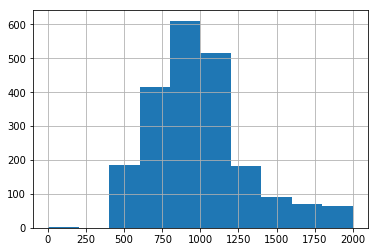

In [516]:
%matplotlib inline
df.chunk.value_counts().hist()